# Covid RX Hackathon - Projects in Advanced Machine Learning
## Davide Vaccari

This document is a report containing **CNN (Machine Learning)** models used to identify whether an individual's RX is normal or has signs of either Pneumonia or Covid-19.

I'll start by using simple models and then I'll combine them with larger models through **Transfer Learning**.

The **dataset** contains:  
Total RX: 3886  
Covid-19: 1200  
Normal: 1341  
Pneumonia: 1345

20% of these are used as test data. Respectively: COVID 240, NORMAL 269, PNEUMONIA 269.

The code (Jupiter Notebook) for this report can be found on my [Covid_Hackathon Repository](https://github.com/davidev7/Covid_Hackathon).

In [ ]:
# Import data and unzip files to folder
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip 

In [ ]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

In [3]:
# Loading libraries

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

(192, 192, 3)

In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
len(image_filepaths)

3886

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


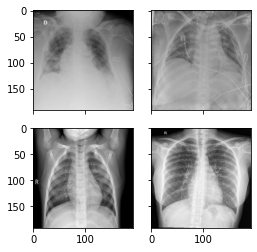

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (100).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1024).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1031).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [11]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

## Let's start with a simple models to use as a reference.

## Convolutional 2D

In [113]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros()),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())
  ])
  
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.2) # dividing lr by 5 when val_accuracy fails to improve after 2 epochs
  
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)

  model.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 15, verbose=1,validation_data=(X_test,y_test), callbacks=[mc,red_lr]) 

In [111]:
print("Number of layers in the model: ", len(model.layers))
print("Number of trainable variables in the model: ", len(model.trainable_variables))
print("Number of parameters in the model: ", model.count_params())

Number of layers in the model:  20
Number of trainable variables in the model:  28
Number of parameters in the model:  122683


In [41]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 0 0 1 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 0 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 0 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 0 0 1 2 2 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 1 2 2 0 2 1 1 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 2 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 0 0 0 1 1 1 1 2 1 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 2 2 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 2 0 2 1 2
 2 0 1 0 0 1 2 0 1 2 0 0 2 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 1 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 0 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 1
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 0 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 2 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [42]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [43]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.956298,0.956692,0.956313,0.95727,0,0,0,0


In [44]:
import tensorflow.keras.backend as K

print(model.get_config()) # Full configuration to fit keras model
print(K.eval(model.optimizer.get_config())) # Optimizer configuration
print(len(model.history.epoch)) # Number of epochs

{'name': 'sequential_5', 'layers': [{'class_name': 'Conv2D', 'config': {'name': 'conv2d_56', 'trainable': True, 'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_57', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'se

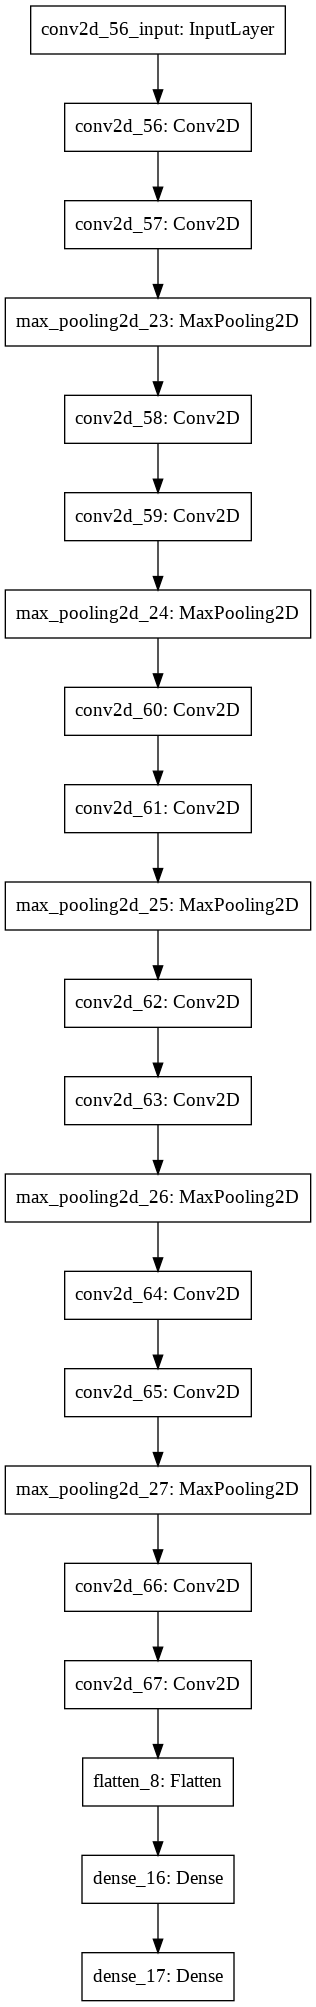

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

## And now with fire modules

In [ ]:
l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(3, activation='softmax',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
            red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.2) # dividing lr by 5 when val_accuracy fails to improve after 2 epochs
  
            opt = tf.keras.optimizers.Adam(learning_rate=0.001)

            model2 = tf.keras.Model(x, y)
        
            model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc']) 
        
            model2.fit(X_train, y_train, 
                    epochs = 15, verbose=1,validation_data=(X_test,y_test), callbacks=[mc,red_lr])

In [62]:
print("Number of layers in the model: ", len(model2.layers))
print("Number of trainable variables in the model: ", len(model2.trainable_variables))
print("Number of parameters in the model: ", model2.count_params())

Number of layers in the model:  28
Number of trainable variables in the model:  34
Number of parameters in the model:  35579


In [51]:
print(predict_classes(model2.predict(X_test)))

prediction_index=predict_classes(model2.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 0 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 0 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 2 1 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 2 0
 0 0 2 2 1 1 2 1 2 1 2 1 1 1 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 2 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 2 2 0 2 1 1 1 2 0 0 1 1 1 1 2 1 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 1 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 2 2 2 1 2 1 1 1 0 2 0 1 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 2 0 2 1 2
 2 1 2 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 2 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 0 2 2 0 0 2 0 1 0 2 1 2 0 1 2 0 1 0 2 2 1 2 0 0 1 0 1 0 0 2 1 0
 0 2 0 0 1 2 2 0 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 1
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 2 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 1 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [52]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.939589,0.940688,0.941422,0.940113,0,0,0,0


Fire modules minimize the parameters and shrink down the model size. However, this model2 performs slightly worse than the first model.

In [ ]:
print(model2.get_config())
print(K.eval(model2.optimizer.get_config()))
print(len(model2.history.epoch))

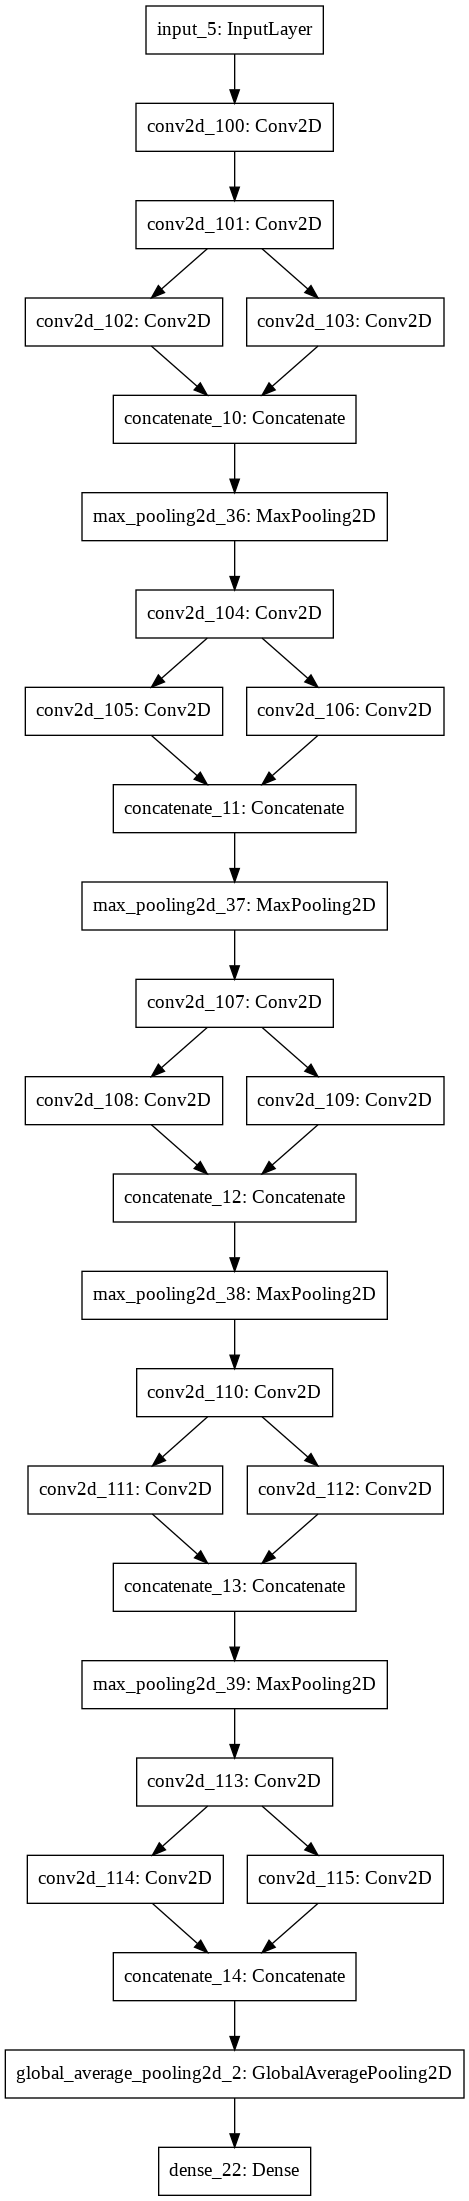

In [54]:
plot_model(model2, to_file='model.png')

---
## Now, let's use Transfer Lerning

# Transfer Learning: Start with pre-established weights and retrain model final output layer to fit new output layer parameters to your data.

I tried "Xception", "Inception", and "VGG19". For this particular dataset, VGG19 always performed better.

## VGG19

In [93]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model = VGG19(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [94]:
len(base_model.trainable_variables)

32

In [95]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  22
Number of layers frozen in the base model:  12


In [96]:
len(base_model.trainable_variables)

14

In [86]:
# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
x = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(base_model.layers[-1].output)
y = fire_module(24, 48)(x)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)



In [ ]:
# example of tending the vgg19 model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

flat1 = Flatten()(y)
class1 = Dense(1024, activation='relu',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(flat1)
class2 = Dense(256, activation='relu',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(class1)
output = Dense(3, activation='softmax', 
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(class2)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg19 model defined in base_model
  
# summarize
model.summary()

In [ ]:
# Fit VGG19 model with some unfrozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  from keras.callbacks import EarlyStopping
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0) # dividing lr by half when val_accuracy fails to improve after 2 epochs
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # save best model given maximum val_accuracy, stop early if loss does not improve after 10 epochs beyond best loss

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 30, verbose=1,validation_data=(X_test,y_test), callbacks=[mc,red_lr, es])

In [65]:
print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 0 0 0 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 1 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 2 0 2
 1 1 1 1 0 2 0 1 2 1 0 2 1 2 0 1 2 2 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 1 2 2 1 2 1 2 1 1 1 2 0 2 0 1 1 2 2 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 1 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 2 2 1 1 2 1 1 1 0 2 0 0 2 2 1 2 2 1 1 0 1 2 0 0 0 1 0 2 2 2 0 2 1 2
 2 0 1 0 0 1 2 0 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 0 2 2 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 0 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 1
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 1 2 2 1 1 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [66]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.957584,0.958318,0.958161,0.958509,0,0,0,0


Accuracy improved slightly from the first model, but, as of now, transfer learning doesn't seem worth it. Let's try it again without fire modules.

In [97]:
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(flat1)
class2 = Dense(256, activation='relu',
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(class1)
output = Dense(3, activation='softmax', 
               kernel_initializer=tf.keras.initializers.glorot_uniform(), 
               bias_initializer=tf.keras.initializers.zeros())(class2)

# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg19 model defined in base_model
  
# summarize
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0  

I've tried different [initializers](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) for both kernel and biases. The ones that performed better where Glorot Uniform and Lecun Uniform for kernel, zeros for biases.

As for the [optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), I tried all the availables and Adam performed better. However, I haven't tuned for the best parameters for every optimizer. I think both Adadelta and Adagrad could have chances to do good.

In [98]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0) # dividing lr by half when val_accuracy fails to improve after 2 epochs
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # save best model given maximum val_accuracy, stop early if loss does not improve after 10 epochs beyond best loss

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 30, verbose=1,validation_data=(X_test,y_test), callbacks=[mc,red_lr, es])

Train on 3108 samples, validate on 778 samples
Epoch 1/30
3104/3108 [============================>.] - ETA: 0s - loss: 0.2195 - acc: 0.9233
Epoch 00001: val_acc improved from -inf to 0.96658, saving model to best_model.h5
3108/3108 [==============================] - 49s 16ms/sample - loss: 0.2192 - acc: 0.9234 - val_loss: 0.0913 - val_acc: 0.9666
Epoch 2/30
3104/3108 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9733
Epoch 00002: val_acc improved from 0.96658 to 0.98201, saving model to best_model.h5
3108/3108 [==============================] - 39s 12ms/sample - loss: 0.0758 - acc: 0.9733 - val_loss: 0.0625 - val_acc: 0.9820
Epoch 3/30
3104/3108 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9771
Epoch 00003: val_acc improved from 0.98201 to 0.98329, saving model to best_model.h5
3108/3108 [==============================] - 39s 12ms/sample - loss: 0.0617 - acc: 0.9772 - val_loss: 0.0597 - val_acc: 0.9833
Epoch 4/30
3104/3108 [===================

In [99]:
print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

labels=pd.get_dummies(y_train).columns

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 1 2 2 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 1 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 1 1 2 1 1 2 0 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 0 1 0 0 1 2 1 0 2 0 0 0
 0 0 2 2 1 2 2 1 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 2 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 2 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 0 2 1 2
 2 0 1 0 0 1 2 2 1 2 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 2 0
 1 0 2 2 1 0 2 2 0 0 2 0 1 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 1 0
 0 2 0 2 1 2 2 0 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 2 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 2 1 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [100]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.992288,0.992486,0.992412,0.992565,0,0,0,0


Ok, I think I got particularly lucky with this training. I ran this model multiple times and I always got a test accuracy from 96.5 to 98.2. For sure this is a great result and I'm going to save this model and upload it to the Hackathon Leaderboard.

In [ ]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [102]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [103]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=True,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 98 -> 49


In [104]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [105]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [107]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 45'

In [ ]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

data=data.loc[data.iloc[:,0:8].duplicated()==False,:] #getting rid of any duplicate model submissions
data.fillna(0,inplace=True)
data

In [109]:
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,99.23%,99.25%,99.24%,99.26%,keras,True,True,Model,26,39162947,str,Adam,"{'name': 'model_11', 'layers':...",dv2438,45
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
3,98.07%,98.11%,98.12%,98.13%,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers':...",dv2438,26
4,97.56%,97.60%,97.57%,97.65%,keras,True,True,Sequential,5,14423555,str,Adam,"{'name': 'sequential_1', 'laye...",prajseth,40
5,97.04%,97.12%,97.18%,97.08%,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,22
6,97.04%,97.12%,97.18%,97.08%,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,18
7,97.04%,97.08%,97.17%,97.13%,keras,True,True,Model,34,20232011,str,Adam,"{'name': 'model_15', 'layers':...",dv2438,28
8,96.92%,96.99%,96.98%,97.01%,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential_1', 'laye...",xcin,23
9,96.92%,96.96%,96.91%,97.03%,keras,True,True,Sequential,5,14423555,str,SGD,"{'name': 'sequential_1', 'laye...",prajseth,39
10,96.66%,96.68%,96.69%,96.67%,keras,True,True,Model,314,55361315,str,Adam,"{'name': 'model_1', 'layers': ...",kka2120,43
